<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [4]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [5]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-06-03 17:45:33--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-06-03 17:45:33 (14.1 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [6]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [7]:
df.shape

(346, 10)

### Convert to date time object 

In [8]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [9]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [10]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    seaborn-0.10.1             |             py_0         160 KB  anaconda
    certifi-2020.4.5.1         |           py36_0         159 KB  anaconda
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    ------------------------------------------------------------
                                           Total:         4.2 MB

The following packages will be UPDATED:

    ca-certificates: 2020.1.1-0         --> 2020.1.1-0        anaconda
    certifi:         2020.4.5.1-py36_0  --> 2020.4.5.1-py36_0 anaconda
    openssl:         1.1.1g-h7b6447c_0  --> 1.1.1g-h7b6447c_0 anaconda
    seaborn:         0.9.0-pyh91

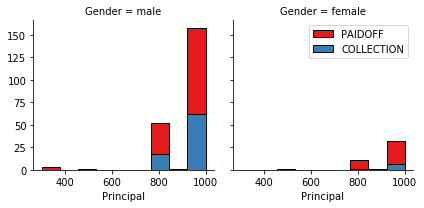

In [11]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

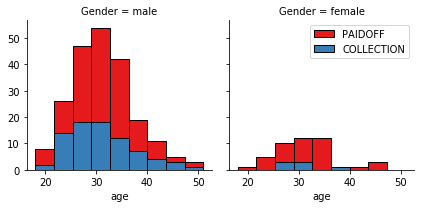

In [12]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

   Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  dayofweek  
0 2016-10-07   45  High School or Below    male          3  
1 2016-10-07   33              Bechalor  female          3  
2 2016-09-22   27               college    male          3  
3 2016-10-08   28               college  female          4  
4 2016-10-08   29               college    male          4  


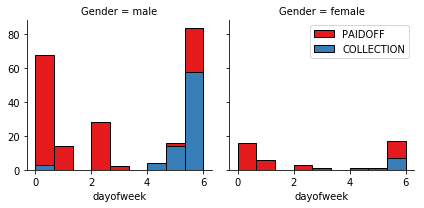

In [13]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
print(df.head())
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()
#So day of the week is correlated to whether or not people will pay off a loan? Interesting

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [14]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()
#This will help us differentiate weekends and weekdays, since it seems people who get loans at the end of the week tend not to pay it off...

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [15]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)#Normalize gives you percentages

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [16]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()
#0 = male, 1 = female

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [17]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [18]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [19]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [20]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [21]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [22]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]
#Training models take in arrays, not dataframes?

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 4)
k = 7 #best k value!
neigh = KNeighborsClassifier(n_neighbors = k)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

[0.67142857 0.65714286 0.71428571 0.68571429 0.75714286 0.71428571
 0.78571429 0.75714286 0.75714286]
Most accurate k is  7  with an accuracy of 0.7857 


Text(0.5, 0, 'Number of Neighbors')

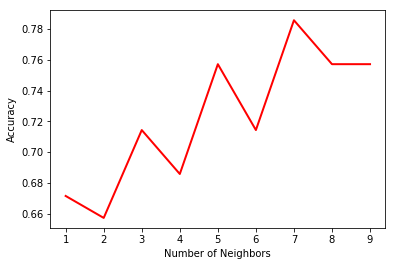

In [25]:
#Finding the best k
k_max = 10
accuracies = np.zeros((k_max-1))
for k in range(1, k_max):
    n = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    predictions = n.predict(X_test)
    accuracies[k-1] = metrics.accuracy_score(y_test, predictions) 

print(accuracies)
print("Most accurate k is ", accuracies.argmax()+1, " with an accuracy of %.4f " % max(accuracies))
plt.plot(range(1,k_max), accuracies,'r', linewidth = 2.0)
plt.ylabel("Accuracy")
plt.xlabel("Number of Neighbors")
    

In [26]:
#Prediction
yhat = neigh.predict(X_test)
print(yhat[0:5])
print(y_test[0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [27]:
#Accuracy assessment:
print("Train set accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set accuracy: ", metrics.accuracy_score(y_test, yhat))
print("Test set jaccard index: ",metrics.jaccard_similarity_score(y_test,yhat))#seems like accuracy_score is same as jaccard_similarity_score...
print("Test set f1-score: ",metrics.f1_score(y_test,yhat, average= 'weighted'))
#print("Test set log loss: ",metrics.log_loss(y_test,yhat)) not applicable because KNN doesn't give probabilities




Train set accuracy:  0.8079710144927537
Test set accuracy:  0.7857142857142857
Test set jaccard index:  0.7857142857142857
Test set f1-score:  0.7766540244416351


# Decision Tree

In [28]:
#Idea: Instead of One Hot Encoding, try just assigning numeric values to categorical data
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [168]:
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 4)
#print(X_train.shape)
#print(X_test.shape)

In [169]:
loanTree = DecisionTreeClassifier(criterion = 'entropy')#how does max_depth affect the model??
loanTree.fit(X, y)
print(loanTree)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [65]:
#predictions = loanTree.predict(X_test)
#print(predictions[0:10])
#print(y_test[0:10])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [66]:
#print("Test set jaccard index: ",metrics.jaccard_similarity_score(y_test,predictions))#seems like accuracy_score is same as jaccard_similarity_score...
#print("Test set f1-score: ",metrics.f1_score(y_test,predictions, average= 'weighted'))
#print("Test set log loss: ",metrics.log_loss(y_test,yhat)) not applicable because KNN doesn't give probabilities

Test set jaccard index:  0.7
Test set f1-score:  0.7142857142857144


In [33]:
?DecisionTreeClassifier

# Support Vector Machine

In [109]:
from sklearn import svm
from sklearn import metrics

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 4)

In [111]:
"""
Kernel functions we can test. Mapping data into a higher dimensional space so we can find a separator
1.Linear (linear)
2.Polynomial (poly)
3.Radial basis function (RBF)
4.Sigmoid (sigmoid)
"""
kernels = ['linear', 'rbf', 'poly', 'sigmoid']


In [112]:

for kernel in kernels:
    print("Kernel type: ", kernel)
    loansvm = svm.SVC(kernel = kernel, gamma = 'auto')
    loansvm.fit(X_train, y_train)
    predictions = loansvm.predict(X_test)
    print("Test set jaccard index: ",metrics.jaccard_similarity_score(y_test,predictions))#seems like accuracy_score is same as jaccard_similarity_score...
    print("Test set f1-score: ",metrics.f1_score(y_test,predictions, average= 'weighted'))
    print("___________________________________________________")

loansvm = svm.SVC(kernel = 'rbf', gamma = 'auto')
loansvm.fit(X,y)

Kernel type:  linear
Test set jaccard index:  0.7857142857142857
Test set f1-score:  0.6914285714285714
___________________________________________________
Kernel type:  rbf
Test set jaccard index:  0.7428571428571429
Test set f1-score:  0.7275882012724117
___________________________________________________
Kernel type:  poly
Test set jaccard index:  0.7714285714285715
Test set f1-score:  0.7064793130366899
___________________________________________________
Kernel type:  sigmoid
Test set jaccard index:  0.7428571428571429
Test set f1-score:  0.6892857142857144
___________________________________________________


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [38]:
?svm.SVC

# Logistic Regression

In [113]:
from sklearn.linear_model import LogisticRegression

In [139]:
#Other solvers to find parameters: ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ 
solvers = ['lbfgs', 'liblinear', 'sag', 'saga']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 4)


In [140]:
for solver in solvers:
    print("Solver: ", solver)
    loanLR = LogisticRegression(C = 0.01, solver = solver)
    loanLR.fit(X_train, y_train)
    predictions = loanLR.predict(X_test)
    prediction_proba = loanLR.predict_proba(X_test)
    print("Test set jaccard index: ",metrics.jaccard_similarity_score(y_test,predictions))
    print("Test set f1-score: ",metrics.f1_score(y_test,predictions, average= 'weighted'))
    print("Test set log loss: ",metrics.log_loss(y_test,prediction_proba))
    print("__________________________________________________")
    
loanLR = LogisticRegression(C = 0.01, solver = 'lbfgs')
loanLR.fit(X,y)
#predict = loanLR.predict(FeatureTest)
#predict_proba = loanLR.predict_proba(FeatureTest)
#print(metrics.jaccard_similarity_score(results,predict))
#print("Test set log loss: ",metrics.log_loss(results,predict_proba))

Solver:  lbfgs
Test set jaccard index:  0.7857142857142857
Test set f1-score:  0.6914285714285714
Test set log loss:  0.4920179847937498
__________________________________________________
Solver:  liblinear
Test set jaccard index:  0.6857142857142857
Test set f1-score:  0.6670522459996144
Test set log loss:  0.5772287609479654
__________________________________________________
Solver:  sag
Test set jaccard index:  0.7857142857142857
Test set f1-score:  0.6914285714285714
Test set log loss:  0.4920153772120901
__________________________________________________
Solver:  saga
Test set jaccard index:  0.7857142857142857
Test set f1-score:  0.6914285714285714
Test set log loss:  0.4920185990598182
__________________________________________________


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

# Model Evaluation using Test set

In [42]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [43]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-06-03 17:48:38--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-06-03 17:48:39 (318 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [72]:
test_df = pd.read_csv('loan_test.csv')
print(test_df.shape)
test_df.head()

(54, 10)


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [73]:
#Converting to datetime object
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
#making new column of number day of the week from datetime objects
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
#creating new column weekend for last days of the week
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
#converting gender to discrete numerical values 0 and 1
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [148]:
results = test_df['loan_status'].values
results[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [47]:
#Use one hot encoding
FeatureTest = test_df[['Principal','terms','age','Gender','weekend']]
FeatureTest = pd.concat([FeatureTest,pd.get_dummies(test_df['education'])], axis=1)
FeatureTest.drop(['Master or Above'], axis = 1,inplace=True)
FeatureTest.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [183]:
#KNN, using best k determined previously
knn = KNeighborsClassifier(n_neighbors = k).fit(X,y)
knnPredictions = knn.predict(FeatureTest)
knnJaccard = metrics.jaccard_similarity_score(knnPredictions,results)
knnf1score = metrics.f1_score(knnPredictions,results, average= 'weighted')
print("Test set jaccard index: ",knnJaccard)
print("Test set f1-score: ",knnf1score)


Test set jaccard index:  0.7407407407407407
Test set f1-score:  0.851063829787234


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [179]:
#DecisionTree
dTree = loanTree
dTreePredictions = dTree.predict(FeatureTest)
dTreeJaccard = metrics.jaccard_similarity_score(dTreePredictions,results)
dTreef1score = metrics.f1_score(dTreePredictions,results, average= 'weighted')
print("Test set jaccard index: ",dTreeJaccard)
print("Test set f1-score: ",dTreef1score)

Test set jaccard index:  0.48148148148148145
Test set f1-score:  0.4500561167227834


In [180]:
#SVM
svm = loansvm
svmPredictions = svm.predict(FeatureTest)
svmJaccard = metrics.jaccard_similarity_score(svmPredictions,results)
svmf1score = metrics.f1_score(svmPredictions,results, average= 'weighted')
print("Test set jaccard index: ", svmJaccard)
print("Test set f1-score: ",svmf1score)

Test set jaccard index:  0.7407407407407407
Test set f1-score:  0.851063829787234


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [184]:
#LogisticRegression (is this just a bad model for this data?)
LR = loanLR
predict = LR.predict(FeatureTest)
predict_proba = LR.predict_proba(FeatureTest)
LRJaccard = metrics.jaccard_similarity_score(predict,results)
LRf1score = metrics.f1_score(results,predict, average = "weighted")
LRLogLoss = metrics.log_loss(results,predict_proba)
print("Test set jaccard index: ",LRJaccard)
print("Test set f1-score: ", LRf1score)
print("Test set log loss: ",LRLogLoss)


Test set jaccard index:  0.25925925925925924
Test set f1-score:  0.10675381263616558
Test set log loss:  24.22127126408146


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [185]:
report = {'Algorithm':  ['KNN', 'Decision Tree','SVM', 'LogisticRegression'],
        'Jaccard': [knnJaccard,  dTreeJaccard, svmJaccard, LRJaccard],
         'F1-Score': [knnf1score, dTreef1score, svmf1score, LRf1score],
          'LogLoss':[None, None, None, LRLogLoss],
        }

report_df = pd.DataFrame (report, columns = ['Algorithm', 'Jaccard', 'F1-Score', 'LogLoss'])
report_df

,Algorithm,Jaccard,F1-Score,LogLoss
0,KNN,0.740741,0.851064,NaN
1,Decision Tree,0.481481,0.450056,NaN
2,SVM,0.740741,0.851064,NaN
3,LogisticRegression,0.259259,0.106754,24.221271


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>